### Map Maker
* Creates a color map of the US showing number of cases of COVID-19 per state
* Tutorial followed: https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

In [1]:
import os
import pandas as pd
import numpy as np
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from utils.Data_Getter import get_confirmed

In [11]:
# Path to the shp map
FILE_DIR = os.getcwd()
SHP_PATH = os.path.join(FILE_DIR, "GIS_US_Map", "tl_2019_us_state.shp")

In [12]:
%matplotlib inline

In [13]:
# Get updated confirmed cases
cases = get_confirmed()  # get_recovered, get_deaths
# Filter for US states with at least 1 case in most recent date
us = cases[cases["Country/Region"] == "US"]
states = us[us.iloc[:,-1] != 0]
print(states.shape)

Reading data: Confirmed_03-15-20.csv
(55, 58)


In [14]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields[1:]]
    records = [y[:] for y in sf.records()]
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

def extract_counts(states, df, idxs, days_back):
    """
    Extracts the number of cumulative cases for each state
    """
    data = []
    for _id in idxs:
        row = states[states["Province/State"] == df.loc[_id]["NAME"]]
        if len(row):
            count = int(row[row.columns[4:(len(row.columns)-days_back)]].max(axis=1).item())
        else:
            count = 0
        data.append(count)
    return data

def compute_colors(num_bins, data, bins=None):
    """
    Returns the color code for a state based on its cumulative cases
    
    Args:
        num_bins (int): The number of bins (should align with length of <color_sq> list)
        data ([int]): number of cases per state, ordered the same as <idxs> 
        bins (np.array): [Optional] pre-definied bin thresholds. If ommitted, equal-sized
            bins are created.
    
    Returns:
        
    """
    color_sq = ['#dadaebFF','#bcbddcF0','#9e9ac8F0','#807dbaF0','#6a51a3F0','#54278fF0'] # Purples
    if bins is None:
        new_data, bins = pd.qcut(data, num_bins, retbins=True, labels=list(range(6)))
    else:
        bins[0] = -1
        new_data = pd.cut(data, bins, retbins=False, labels=list(range(6)))
    color_ton = [color_sq[i] for i in new_data]
    colors = sns.color_palette("Purples", n_colors=num_bins)
    sns.palplot(colors, 0.6)
    bins[0] = 0
    for i in range(num_bins):
        print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                " => "+str(int(bins[i+1])-1), end =" ")
    print("\n\n   1   2   3   4   5   6")
    return color_ton, bins

In [15]:
def plot_data(figsize, num_bins, states, days_back=0, bins=None):
    """
    Creates plot of each state with color corresponding to binned cases
    
    Args:
        states (pandas.dataframe): The US states data from GitHub
        days_back (int): Specifies number of days old data to use
        bins (np.array): [Optional] pre-definied bin thresholds. If ommitted, equal-sized
            bins are created.
    
    Returns:
        plt (matplotlib.figure): The plot with all layers on it
        bins (np.array): The bin thresholds used
    """
    # Initialize Visualization Set
    sns.set(style="whitegrid", palette="pastel", color_codes=True)
    sns.mpl.rc("figure", figsize=figsize)
    sf = shp.Reader(SHP_PATH)
    df = read_shapefile(sf)
    
    # Acquire list of map indexes for the continental states
    idxs = [ix for ix in list(df.index) if ix not in [31, 34, 35, 36, 40, 41, 49]]
    
    # Compute state colors
    data = extract_counts(states, df, idxs, days_back)
    color_ton, bins = compute_colors(num_bins, data, bins)
    
    # Plot map
    plt.figure(figsize=figsize)
    fig, ax = plt.subplots(figsize=figsize)
    # Loop through states
    for _, _id in enumerate(idxs):
        shape = sf.shapeRecords()[_id]
        # Plot state shape
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
        # Write state abbreviation
        x0 = (min(x) + max(x)) / 2
        y0 = (min(y) + max(y)) / 2
        ax.text(x0, y0, df.loc[_id]["STUSPS"], fontsize=10)
        # Fill in with color map
        shape_ex = sf.shape(_id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon, y_lat, color_ton[_])
    return plt, bins

def plot_past_data(figsize, num_bins, states, days_back, bins=None):
    """
    Allows you to plot previous data, using pre-defined bin thresholds
    """
    plt, bins = plot_data(figsize, num_bins, states, days_back, bins)
    return plt, bins


1: 0 => 7 
2: 8 => 12 
3: 13 => 23 
4: 24 => 34 
5: 35 => 92 
6: 93 => 731 

   1   2   3   4   5   6


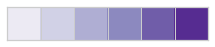

<Figure size 792x648 with 0 Axes>

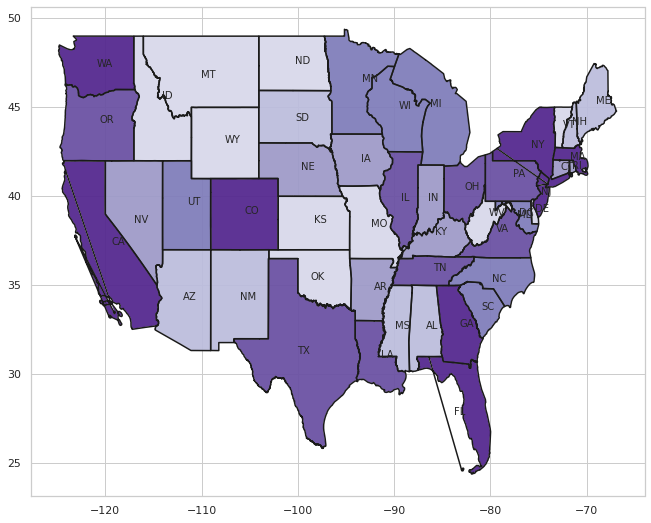

In [16]:
figsize = (11,9)
num_bins = 6
days_back = 0
plt, bins = plot_data(figsize, num_bins, states, days_back)
plt.show()

In [58]:
bins

array([  0,   8,  13,  24,  35,  93, 732], dtype=int64)


1: -1 => 7 
2: 8 => 12 
3: 13 => 23 
4: 24 => 34 
5: 35 => 92 
6: 93 => 731 

   1   2   3   4   5   6


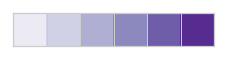

<Figure size 792x648 with 0 Axes>

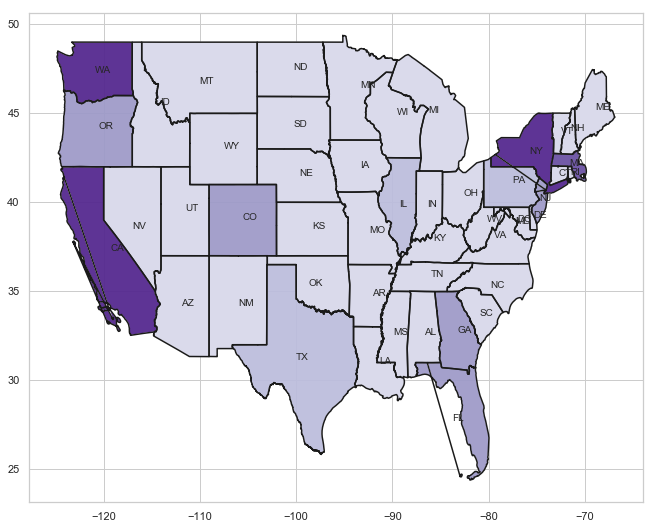

In [82]:
# Get maps from previous days
days_back = 5
plt, bins = plot_past_data(figsize, num_bins, states, days_back, bins)
plt.show()